The measured and model response matrices are defined by

$$\begin{pmatrix} x \\ y \end{pmatrix} = M_{meas,model} \begin{pmatrix} \theta_x \\ \theta_y \end{pmatrix}$$
where $\theta_x$and $\theta_y$  are the changes in steering magnet strengths,
and x , y are the resulting orbit perturbations.

The parameters in the used model is varied by LOCO to minimize the $ \chi^2 $ deviation between the model
and measured orbit response matrices $M_{model}$ and $M_{measured}$
$$  \chi^2 = \sum_{i,j} \frac{(M_{model,i,j}-M_{measured,i,j})^2}{\sigma^2_{i}} = \sum_{i,j} E_{k=(i,j)}^2 $$

The $\chi^2$ minimization is achieved by iteratively solving the linear equation
$$E_{k}^{new}= E_k +\frac{\partial{E_k}}{\partial{k_l}} \Delta k_l =0$$
$$-E_k= \frac{\partial{E_k}}{\partial{k_l}} \Delta k_l$$


In [1]:
print(f"LOCO, AT version")
from at import *
from pylab import *
from at_modules import *
from at.load import load_mat
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import csv
from random import random

LOCO, AT version


In [2]:
# The lattice

from lattice import *
ring=at.Lattice(ring4, energy=1)
ring.radiation_off()

preparing twiss ..
Tunes=[0.21961158 0.11966805]
Chrom=[-0.13386764 -0.09812451]


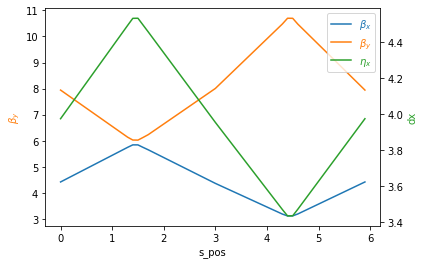

In [3]:
twiss = getOptics(ring, '*', 'beta', 'False')
make_plot(twiss)

(2, 2)


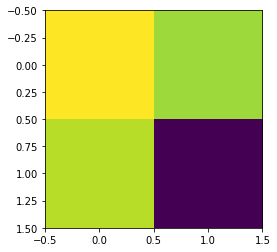

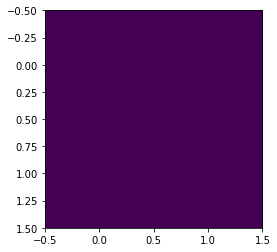

In [4]:
Cxx, Cxy= ORM_x(1.e-4, ring)
Cyy, Cyx= ORM_y(1.e-4, ring)

print(shape(Cxx))

plt.figure()
imshow(Cxx)
plt.show()

plt.figure()
imshow(Cxy)
plt.show()

In [5]:
%%time

quads_info = quad_info(ring)
quad_dict,quad_vals = getQuadFamilies(quads_info)
quads = [ k for k in quad_dict.keys()]

dk = 0.0001
qxx = []
qxy =[]
qyy = []
qyx =[]
quad_names = quads
for qname in quad_names:
    print('generating response to {}, n={}'.format(qname, quad_dict[qname]))
    nq = quad_dict[qname]+1
    for i in range(0,nq):
       Qxx, Qxy, Qyy, Qyx = computeOpticsD(ring, qname, i, dk, quad_vals)
       qxx.append(Qxx)
       qxy.append(Qxy)
       qyy.append(Qyy)
       qyx.append(Qyx)

Done...
generating response to QF, n=0
generating response to QS, n=0
generating response to QD, n=0
Wall time: 43.9 ms


In [6]:
C0x = Cxx
C0y = Cyy
C0xy = Cxy
C0yx = Cyx

dCx = []
dCy = []
dCxy = []
dCyx = []
quad_names = quads
for qname in quad_names:
    nquad = quad_dict[qname]
    print('loading response to:',qname)
    for i in range(0,nquad+1):

        C1x = qxx[i]
        C1y = qyy[i]
        C1xy = qxy[i]
        C1yx = qyx[i]

        dCx.append( (C1x-C0x)  / dk)
        dCy.append( (C1y-C0y) /dk)
        dCxy.append( (C1xy-C0xy)/ dk)
        dCyx.append( (C1yx-C0yx)/ dk)

loading response to: QF
loading response to: QS
loading response to: QD


simulating perturbed machine...
Done...
preparing twiss ..
Tunes=[0.22088061 0.1202278 ]
Chrom=[-0.13547239 -0.09974288]


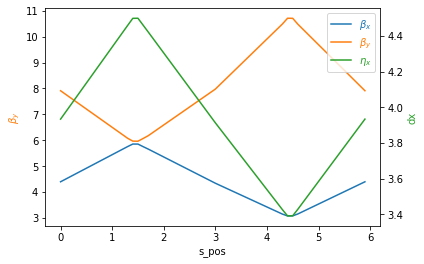

In [7]:
## simulate_errors

errorQF = 72.e-3 #0.01
errorQD = 52.e-3 #0.01
tiltQF = 0.003
tiltQD = 0.003
tiltQS = 0.7853981633974483
quads_info_error = simulateError_tilt(ring,errorQF,errorQD,tiltQF ,tiltQD ,tiltQS)
twiss_error = getOptics(ring, '*', 'beta', 'True')
make_plot(twiss_error)

In [9]:
# ORM Cx, Cy

Cxx_err, Cxy_err= ORM_x_error(1.e-4, ring)
Cyy_err, Cyx_err= ORM_y_error(1.e-4, ring)

print(shape(Cxx_err))

(2, 2)


In [41]:
Cxy_err

array([[ 0.01744925,  0.0164699 ],
       [ 0.00047405, -0.00440429]])

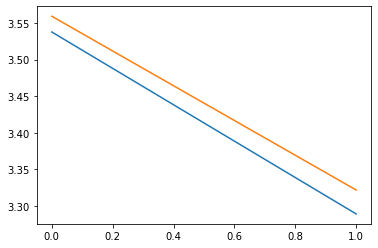

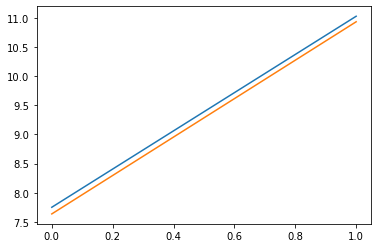

In [10]:
plt.plot(Cxx_err[0])
plt.plot((Cxx[0]))
plt.show()


plt.plot(Cyy[0])
plt.plot((Cyy_err[0]))
plt.show()

In [12]:
Cxy_err

array([[ 0.01744925,  0.0164699 ],
       [ 0.00047405, -0.00440429]])

In [15]:
QS_indexes = get_refpts(ring, 'QS')

lindata0, tune, chrom, lindata = ring.linopt(get_chrom=True, refpts=QS_indexes)
s_pos = lindata['s_pos']
beta_x= lindata['beta'][:, 0]
beta_y= lindata['beta'][:, 1]

print("preparing twiss ..")
print(f"Tunes={ring.get_tune()}")
print(f"Chrom={ring.get_chrom()}")

preparing twiss ..
Tunes=[0.22088061 0.1202278 ]
Chrom=[-0.13547239 -0.09974288]


$$\Delta\nu_{min} = (k / 2\pi) \sqrt{\beta_x\beta_y}$$

In [29]:
Qs_strength = ((tune[0]-tune[1])*2*pi)/sqrt(beta_x*beta_y)

In [30]:
for i in QS_indexes:
    ring[i].K = Qs_strength

(2, 2)


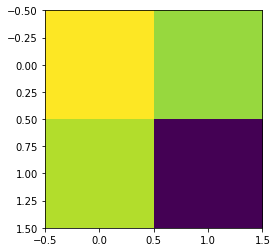

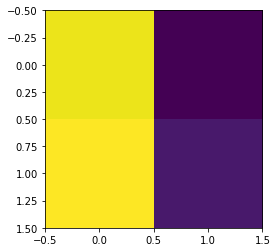

In [39]:
Cxx, Cxy_corrected= ORM_x(1.e-4, ring)
Cyy, Cyx_corrected= ORM_y(1.e-4, ring)

print(shape(Cxx))

plt.figure()
imshow(Cxx)
plt.show()

plt.figure()
imshow(Cxy)
plt.show()

In [42]:
Cxy_err

array([[ 0.01744925,  0.0164699 ],
       [ 0.00047405, -0.00440429]])

In [40]:
Cxy_corrected

array([[-0.27650486, -0.40321648],
       [-0.2724749 , -0.39410535]])

In [10]:
Nk = len(dCx) #number of free parameters
Nm = 40 # number of measurements
print('NK:', Nk)
print('Nm:', Nm)

Ax = np.zeros([Nk,Nk])
Ay = np.zeros([Nk,Nk])
Axy = np.zeros([Nk,Nk])
Ayx = np.zeros([Nk,Nk])

A = np.zeros([4*Nk,Nk])


##

Bx = np.zeros([Nk,1])
By = np.zeros([Nk,1])
Bxy = np.zeros([Nk,1])
Byx = np.zeros([Nk,1])

B = np.zeros([4*Nk,1])

##

Dx = (Cxx_err[0:Nm,:] - C0x[0:Nm,:]) ### dk ?
Dy = (Cyy_err[0:Nm,:] - C0y[0:Nm,:])
Dxy = (Cxy_err[0:Nm,:] - C0xy[0:Nm,:])
Dyx = (Cyx_err[0:Nm,:] - C0yx[0:Nm,:])

##

for i in range(Nk): ## i represents each quad
    #print('done A:', 100.* i ,'%')
    for j in range(Nk):
        Ax[i,j] = np.sum(np.dot(dCx[i],dCx[j].T) )
        Ay[i,j] = np.sum(np.dot(dCy[i],dCy[j].T) )
        Axy[i,j] = np.sum(np.dot(dCxy[i],dCxy[j].T) )
        Ayx[i,j] = np.sum(np.dot(dCyx[i],dCyx[j].T) )
    A[i,:] = Ax[i,:]
    A[i+Nk,:] = Ay[i,:]
    A[i+2*Nk,:] = Axy[i,:]
    A[i+3*Nk,:] = Ayx[i,:]

##

for i in range(Nk):
    Bx[i] = np.sum( np.dot(dCx[i], Dx.T) )
    By[i] = np.sum( np.dot(dCy[i], Dy.T) )
    Bxy[i] = np.sum( np.dot(dCxy[i], Dxy.T) )
    Byx[i] = np.sum( np.dot(dCyx[i], Dyx.T) )
    B[i] = Bx[i]
    B[i+Nk] = By[i]
    B[i+2*Nk] = Bxy[i]
    B[i+3*Nk] = Byx[i]

NK: 3
Nm: 40


[5.44280082e-04 5.17416674e+12 2.81474977e+14]
number of singular values 3
A(12, 3) B(12, 1) U(12, 12) smat(12, 3) v(3, 3)


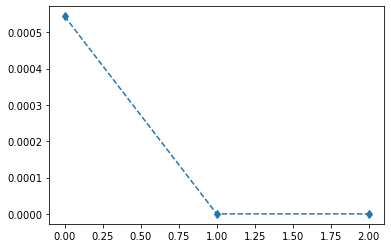

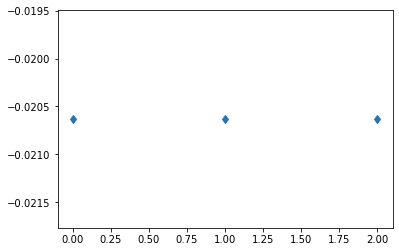

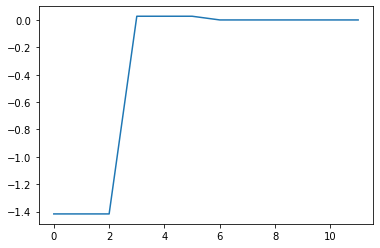

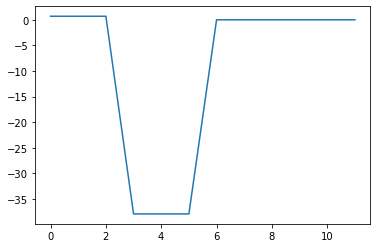

In [31]:
u,s,v=np.linalg.svd(A,full_matrices=True)

smat = 0.0 * A
si = s**-1
print(si)
n_sv = 1
si[n_sv:] *= 0.0

print("number of singular values {}".format(len(si)))
smat[:Nk,:Nk] = np.diag(si)


print('A'+str(A.shape), 'B'+str(B.shape),'U'+str(u.shape), 'smat'+str(smat.shape), 'v'+str(v.shape))


plt.plot(si,'d--')
plt.show()


Ai=np.dot(v.transpose(),np.dot(smat.transpose(),u.transpose()))

###
r = ( np.dot(Ai,B)).reshape(-1)
plot(r,'d')
plt.show()


# error
e = np.dot(A,r).reshape(-1) - B.reshape(-1)
plt.plot(e)
plt.show()
plt.plot(B)
plt.show()

In [32]:
si

array([0.00054428, 0.        , 0.        ])

In [33]:
# check correction...
quad_dict,quad_vals = getQuadFamilies(quads_info_error)
n_list = len(quads_info_error.s_pos)
print(n_list)

quad_names = quad_names
iq = 0
frac = 1.0
cor_dict = {}
for qname in quad_names:
    nquad = quad_dict[qname]
    #print(qname, quad_dict[qname])
    for i in range(0, nquad):
        cor_dict[qname, i+1] = -r[iq]*frac
        iq += 1

3


In [34]:
DK = []
for idx in range(n_list):
   qname_ = quads_info.elements_name[idx]  # ElementName

   if qname_ == 'QF':
      occ = quads_info_error.occ[idx]
      dk = cor_dict['QF',occ]
      DK.append(dk)

   if qname_ == 'QD':
      occ = quads_info_error.occ[idx]
      dk = cor_dict['QD',occ]
      DK.append(dk)


   if qname_ == 'QS':
      occ = quads_info_error.occ[idx]
      dk = cor_dict['QS',occ]
      DK.append(dk)

quads_indexes = get_refpts(ring, elements.Quadrupole)
i = 0
while (i < len(quads_indexes)):
      ring[quads_indexes[i]].K += DK[i]
      i += 1

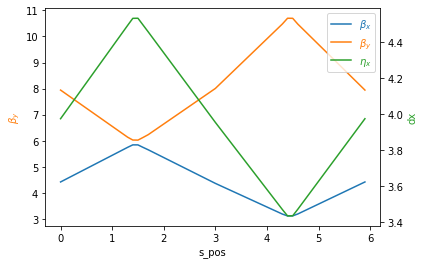

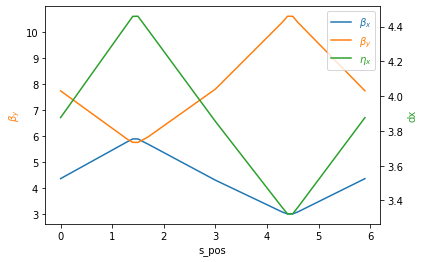

preparing twiss ..
Tunes=[0.22416085 0.12033061]
Chrom=[-0.13922269 -0.10285123]


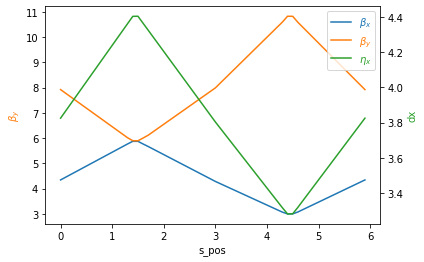

In [35]:
make_plot(twiss)
make_plot(twiss_error)
twiss_corrected = getOptics(ring, '*', 'beta', 'True')
make_plot(twiss_corrected)

In [36]:
twiss_error

,s_pos,betax,betay,dx,dy
0,0.0,4.369091,7.741576,3.876224,0.413176
1,1.3,5.791962,5.875629,4.417374,0.412504
2,1.3,5.791962,5.875629,4.417374,0.412504
3,1.4,5.894734,5.763689,4.458624,0.412504
4,1.4,5.894734,5.763689,4.458624,0.412504
5,1.5,5.893860,5.760533,4.459216,-0.400691
6,1.6,5.789367,5.866062,4.419147,-0.400691
7,1.7,5.689232,5.975990,4.379078,-0.400691
8,3.0,4.311039,7.805333,3.854908,-0.399081
9,4.3,3.085424,10.378048,3.358452,-0.358405


In [16]:
twiss_corrected

,s_pos,betax,betay,dx,dy
0,0.0,4.294118,7.950795,3.833153,0.399223
1,1.3,5.694730,6.086064,4.358570,0.402451
2,1.3,5.694730,6.086064,4.358570,0.402451
3,1.4,5.796886,5.973234,4.398815,0.402451
4,1.4,5.796886,5.973234,4.398815,0.402451
5,1.5,5.796886,5.973234,4.398815,-0.402451
6,1.6,5.694730,6.086064,4.358570,-0.402451
7,2.9,4.294118,7.950795,3.833153,-0.399223
8,4.2,3.058611,10.554565,3.337579,-0.356917
9,4.2,3.058611,10.554565,3.337579,-0.356917
